In [347]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot as plt

In [546]:
df = pd.read_csv("Data/Data.csv")
df = df[["country", "commodity", "loss_percentage", "activity", "food_supply_stage"]]
df

,country,commodity,loss_percentage,activity,food_supply_stage
0,Myanmar,"Groundnuts, excluding shelled",5.22,NaN,Whole supply chain
1,Myanmar,"Groundnuts, excluding shelled",5.43,NaN,Whole supply chain
2,Myanmar,"Groundnuts, excluding shelled",5.61,NaN,Whole supply chain
3,Myanmar,"Groundnuts, excluding shelled",5.40,NaN,Whole supply chain
4,Myanmar,"Groundnuts, excluding shelled",5.00,NaN,Whole supply chain
...,...,...,...,...,...
27768,Zambia,Millet,1.27,Storage,Farm
27769,Zambia,Millet,2.50,Winnowing,Farm
27770,Zambia,Millet,1.00,Transportation,Transport
27771,Zambia,Millet,2.38,Storage,Storage


In [547]:
# df[df.food_supply_stage=="Whole supply chain"]

Missing values mostly belong to the rows whose food_supply_stage refer to 'Whole supply chain'.

In [548]:
df=df.dropna(axis=0).reset_index().drop(["index"],axis=1)

In [549]:
# def prep(df):
#     X=df[["country","commodity","food_supply_stage","activity"]]
#     splitted=X['activity'].str.split(',', expand=True)
#     X=pd.concat([X,splitted],axis=1)
#     X.drop(["activity"],axis=1,inplace=True)
#     listt=[]
#     for col in range(0,11):
#         listt.append(set(X[col].unique()))
#     listtt=[]
#     for i in range(0,11):
#         for item in listt[i]:
#             if item==None:
#                 continue
#             listtt.append(item.strip())
#     listtt=list(set(listtt))
#     listtt.sort()

#     zeros=np.zeros([X.shape[0],len(listtt)],int)
#     activity_cols=pd.DataFrame(zeros,columns=listtt)

#     X=X.applymap(lambda x: x.split()[0] if x!=None else x )

#     dummies_0=pd.get_dummies(X[0],columns=listtt)
#     dummies_1=pd.get_dummies(X[1],columns=listtt)
#     dummies_2=pd.get_dummies(X[2],columns=listtt)
#     dummies_3=pd.get_dummies(X[3],columns=listtt)
#     dummies_4=pd.get_dummies(X[4],columns=listtt)
#     dummies_5=pd.get_dummies(X[5],columns=listtt)
#     dummies_6=pd.get_dummies(X[6],columns=listtt)
#     dummies_7=pd.get_dummies(X[7],columns=listtt)
#     dummies_8=pd.get_dummies(X[8],columns=listtt)
#     dummies_9=pd.get_dummies(X[9],columns=listtt)
#     dummies_10=pd.get_dummies(X[10],columns=listtt)

#     arr=[dummies_0,dummies_1,dummies_2,dummies_3,dummies_4,dummies_5,dummies_6,dummies_7,dummies_8,dummies_9,dummies_10]
#     for i in arr:
#         for col in i.columns:
#             activity_cols[col]=activity_cols[col].where(activity_cols[col]>i[col],i[col])
    
#     X=pd.concat([X,activity_cols],axis=1)

#     X.drop([0,1,2,3,4,5,6,7,8,9,10],axis=1,inplace=True)

#     dummies=pd.get_dummies((X[["country","commodity","food_supply_stage"]]))
#     X=pd.concat([X,dummies],axis=1)
#     X.drop(["country","commodity","food_supply_stage"],axis=1,inplace=True)

#     return X

In [550]:
country="Burundi"
commodity="Wheat"
food_supply_stage="Farm"
df_select=df[df.country==country]
df_select=df_select[df_select.commodity==commodity]
df_select=df_select[df_select.food_supply_stage==food_supply_stage]
df_select["activity"].unique()

array(['Shelling, Threshing', 'Storage', 'Transportation'], dtype=object)

In [551]:
for x in ['loss_percentage']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

In [552]:
df.isnull().sum()


country                 0
commodity               0
loss_percentage      1043
activity                0
food_supply_stage       0
dtype: int64

In [553]:
df = df.dropna(axis = 0)

In [554]:
df.reset_index(inplace=True)
df

,index,country,commodity,loss_percentage,activity,food_supply_stage
0,0,Burundi,Wheat,3.50,"Shelling, Threshing",Farm
1,1,Burundi,Wheat,4.87,Storage,Farm
2,2,Burundi,Wheat,2.50,Transportation,Farm
3,3,Burundi,Wheat,4.43,"Drying, Harvesting",Harvest
4,4,Burundi,Maize (corn),4.00,Drying,Farm
...,...,...,...,...,...,...
19822,20865,Zambia,Millet,1.27,Storage,Farm
19823,20866,Zambia,Millet,2.50,Winnowing,Farm
19824,20867,Zambia,Millet,1.00,Transportation,Transport
19825,20868,Zambia,Millet,2.38,Storage,Storage


In [555]:
df.drop(["index"],axis=1,inplace=True)
df.country = df.country.str.replace(' ', '')

In [556]:
X=df[["country","commodity","food_supply_stage","activity"]]
Y=df.loss_percentage

In [557]:
splitted=X['activity'].str.split(',', expand=True)

In [558]:
X=pd.concat([X,splitted],axis=1)

In [559]:
X.drop(["activity"],axis=1,inplace=True)

In [560]:
listt=[]
for col in range(0,10):
    listt.append(set(X[col].unique()))

listtt=[]
for i in range(0,10):
    for item in listt[i]:
        if item==None:
            continue
        listtt.append(item.strip())
listtt=list(set(listtt))
listtt.sort()

zeros=np.zeros([X.shape[0],len(listtt)],int)
activity_cols=pd.DataFrame(zeros,columns=listtt)
activity_cols

,Assembling,Bagging,Bundling,Cleaning,Collection,Consumption,Curing,Distribution,Drying,Exporting,...,Sifting,Sorting,Stacking,Storage,Threshing,Trading,Transportation,Unloading,Wholesale,Winnowing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [561]:
X=X.applymap(lambda x: x.split()[0] if x!=None else x)
dummies_0=pd.get_dummies(X[0],columns=listtt)
dummies_1=pd.get_dummies(X[1],columns=listtt)
dummies_2=pd.get_dummies(X[2],columns=listtt)
dummies_3=pd.get_dummies(X[3],columns=listtt)
dummies_4=pd.get_dummies(X[4],columns=listtt)
dummies_5=pd.get_dummies(X[5],columns=listtt)
dummies_6=pd.get_dummies(X[6],columns=listtt)
dummies_7=pd.get_dummies(X[7],columns=listtt)
dummies_8=pd.get_dummies(X[8],columns=listtt)
dummies_9=pd.get_dummies(X[9],columns=listtt)
# dummies_10=pd.get_dummies(X[10],columns=listtt)

arr=[dummies_0,dummies_1,dummies_2,dummies_3,dummies_4,dummies_5,dummies_6,dummies_7,dummies_8,dummies_9]
for i in arr:
    for col in i.columns:
        activity_cols[col]=activity_cols[col].where(activity_cols[col]>i[col],i[col])

X=pd.concat([X,activity_cols],axis=1)
X.drop([0,1,2,3,4,5,6,7,8,9],axis=1,inplace=True)

dummies=pd.get_dummies((X[["country","commodity","food_supply_stage"]]))
X=pd.concat([X,dummies],axis=1)
X.drop(["country","commodity","food_supply_stage"],axis=1,inplace=True)
X

,Assembling,Bagging,Bundling,Cleaning,Collection,Consumption,Curing,Distribution,Drying,Exporting,...,food_supply_stage_Market,food_supply_stage_Packing,food_supply_stage_Post-harvest,food_supply_stage_Processing,food_supply_stage_Retail,food_supply_stage_Storage,food_supply_stage_Trader,food_supply_stage_Transport,food_supply_stage_Whole,food_supply_stage_Wholesale
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [571]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)
# X_train, X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

# Artificial Neural Network

In [491]:
model=MLPRegressor().fit(X_train, Y_train)
y_pred=model.predict(X_test)
print("MAPE (Before Tuning)=",mean_absolute_percentage_error(Y_test,y_pred))

# # MODEL TUNING
# mlp_params={"alpha":[10,1, 0.1],
#              "hidden_layer_sizes":[(50,50)],
#              "learning_rate_init":[0.001,0.01,0.1,1]}
# mlp_cv_model=GridSearchCV(model,mlp_params,cv=5, verbose=2, n_jobs=-1).fit(X_train,Y_train)
# print(mlp_cv_model.best_params_)
# # {'alpha': 1, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}

#final modeli oluşturma
mlp_tuned=MLPRegressor(alpha=0.1, hidden_layer_sizes=(50,50), activation="relu", learning_rate_init=0.001).fit(X_train,Y_train)
y_pred_mlp=mlp_tuned.predict(X_test)  #x_val vardı/////////////////////////////////////////////////////////////////////////////////////////////////////


MAPE (Before Tuning)= 0.2815445851158032


In [492]:
print("MAPE=",np.mean(np.abs((y_pred_mlp - Y_test) /Y_test))*100)
    
print("MAE=",mean_absolute_error(Y_test,y_pred_mlp))
y_pred_ann=mlp_tuned.predict(X_test)
print(mlp_tuned.score(X_test, Y_test))

MAPE= 27.151125858496915
MAE= 0.16452935069940378
0.8949062986022649


# Deep Learning

In [494]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [495]:
dnn_model = tf.keras.Sequential([
    layers.Dense(217),
    layers.Dense(250, activation="relu"),
    layers.Dense(50, activation="relu"),
    layers.Dense(1, activation="linear")
])

dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mean_absolute_error')

history = dnn_model.fit(
    X_train,
    Y_train,
    epochs=500,
    verbose=2,
    validation_split = 0.3)

Epoch 1/500
347/347 - 1s - loss: 1.0036 - val_loss: 0.6200 - 1s/epoch - 3ms/step
Epoch 2/500
347/347 - 1s - loss: 0.5130 - val_loss: 0.4550 - 546ms/epoch - 2ms/step
Epoch 3/500
347/347 - 1s - loss: 0.3553 - val_loss: 0.3116 - 538ms/epoch - 2ms/step
Epoch 4/500
347/347 - 1s - loss: 0.2722 - val_loss: 0.2693 - 538ms/epoch - 2ms/step
Epoch 5/500
347/347 - 1s - loss: 0.2363 - val_loss: 0.2398 - 556ms/epoch - 2ms/step
Epoch 6/500
347/347 - 1s - loss: 0.2111 - val_loss: 0.2172 - 586ms/epoch - 2ms/step
Epoch 7/500
347/347 - 1s - loss: 0.1949 - val_loss: 0.2115 - 534ms/epoch - 2ms/step
Epoch 8/500
347/347 - 1s - loss: 0.1844 - val_loss: 0.2029 - 549ms/epoch - 2ms/step
Epoch 9/500
347/347 - 1s - loss: 0.1755 - val_loss: 0.1957 - 540ms/epoch - 2ms/step
Epoch 10/500
347/347 - 1s - loss: 0.1685 - val_loss: 0.1884 - 532ms/epoch - 2ms/step
Epoch 11/500
347/347 - 1s - loss: 0.1605 - val_loss: 0.1809 - 549ms/epoch - 2ms/step
Epoch 12/500
347/347 - 1s - loss: 0.1545 - val_loss: 0.1796 - 533ms/epoch - 2

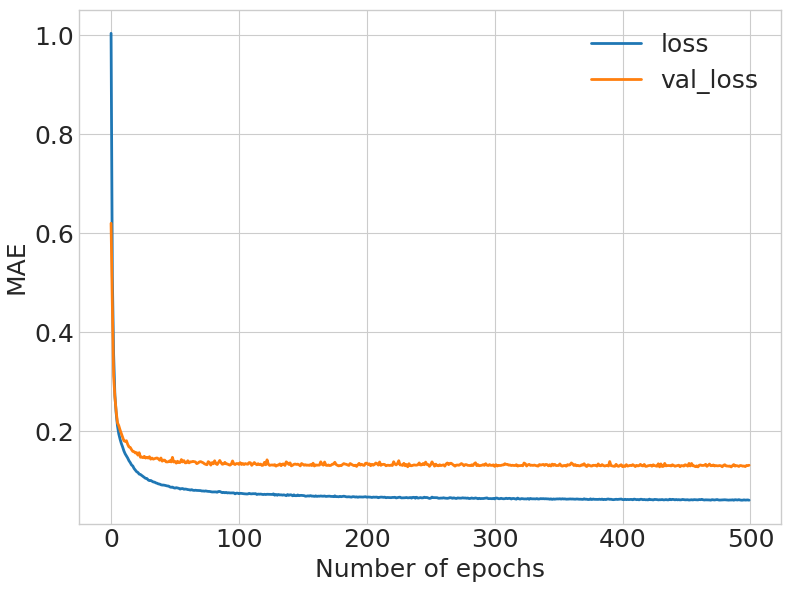

In [496]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history.history['loss'], linewidth=2, label='loss')
    ax.plot(history.history['val_loss'], linewidth=2, label='val_loss')
 
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax.set_xlabel('Number of epochs',fontsize=18)
    ax.set_ylabel('MAE',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

In [497]:
results = dnn_model.evaluate(X_test, Y_test, verbose=0)
test_predictions = dnn_model.predict(X_test).flatten()
results

124/124 [==============================] - 0s 850us/step


0.14118444919586182

In [498]:
np.mean(np.abs((test_predictions - Y_test) /Y_test))*100

25.394486502406348

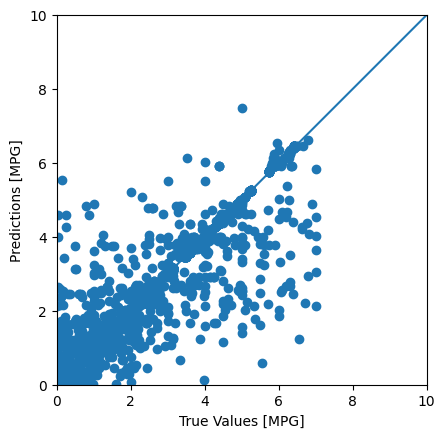

In [467]:
a = plt.axes(aspect='equal')
plt.scatter(Y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Gradient Boosting Regressor

In [598]:
from sklearn.ensemble import GradientBoostingRegressor

In [599]:
gbr_params = {'n_estimators': 700,
          'max_depth': 50,

          'min_samples_split': 5,
          'learning_rate': 0.01,
        #   'alpha':0.1,
            'validation_fraction':0.3,
          'loss': 'ls'}
        
reg = GradientBoostingRegressor(random_state=0, **gbr_params, verbose=2)
reg.fit(X_train, Y_train)
# GradientBoostingRegressor(random_state=0)
test_predictions_gbr = reg.predict(X_test)
print(reg.score(X_test, Y_test))
print("MAPE =", np.mean(np.abs((test_predictions_gbr - Y_test) /Y_test))*100, "%")

/Users/murathansaygili/Desktop/SIC/venv/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           2.1003            1.19m
         2           2.0600            1.12m
         3           2.0204            1.11m
         4           1.9816            1.10m
         5           1.9436            1.09m
         6           1.9064            1.09m
         7           1.8699            1.08m
         8           1.8341            1.08m
         9           1.7990            1.08m
        10           1.7647            1.07m
        11           1.7310            1.07m
        12           1.6980            1.07m
        13           1.6655            1.06m
        14           1.6336            1.06m
        15           1.6026            1.06m
        16           1.5720            1.05m
        17           1.5421            1.05m
        18           1.5128            1.05m
        19           1.4841            1.05m
        20           1.4559            1.05m
        21           1.4282            1.05m
        2

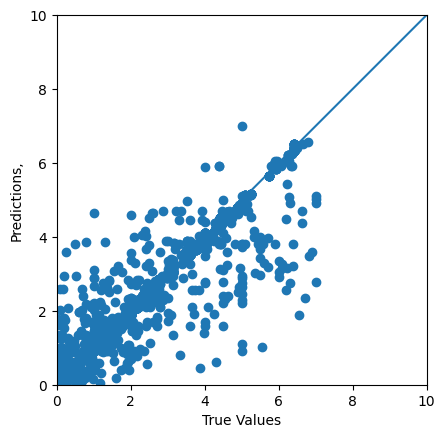

In [600]:
# 0.5094691446658193
# MAPE = 30.637628316249042
a = plt.axes(aspect='equal')
plt.scatter(Y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions,')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Support Vector Machines

In [431]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score,cross_val_predict

In [503]:
regressor = SVR(kernel='rbf',C=10, gamma="scale")
regressor.fit(X_train,Y_train)

SVR(C=10)

In [504]:
# y_pred_svr = regressor.predict(X_test)

y_pred_svr_cv=cross_val_predict(regressor,X_test,Y_test,cv=10)

In [505]:
scores = cross_val_score(regressor, X_test, Y_test, cv=5)
scores

In [506]:
np.mean(np.abs((y_pred_svr_cv - Y_test) /Y_test))*100

43.6335803097699

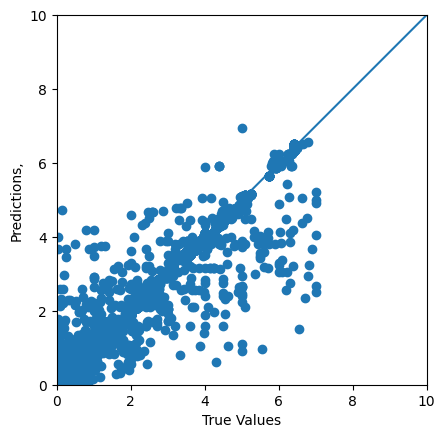

In [479]:
# 0.5094691446658193
# MAPE = 30.637628316249042
a = plt.axes(aspect='equal')
plt.scatter(Y_test, y_pred_svr)
plt.xlabel('True Values')
plt.ylabel('Predictions,')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [510]:
test_predictions = regressor.predict(X_test)
print("MAPE =", np.mean(np.abs((test_predictions - Y_test)/Y_test))*100, "%")

MAPE = 27.73387775552349 %


In [424]:
from sklearn.svm import SVR
C_range = np.logspace(-1, 2, 4)
print(f'The list of values for C are {C_range}')
# List of gamma values
gamma_range = np.logspace(-1, 2, 4)
print(f'The list of values for gamma are {gamma_range}')


The list of values for C are [  0.1   1.   10.  100. ]
The list of values for gamma are [  0.1   1.   10.  100. ]


In [507]:
svr = SVR()
svr.fit(X_train,Y_train)
param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }


# Define grid search
grid_search = GridSearchCV(svr, 
                           param_grid=param_grid, 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=2)
# Fit grid search
grid_result = grid_search.fit(X_train, Y_train)
# Print grid search summary
grid_result


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ......................C=0.1, gamma=1.0, kernel=poly; total time= 1.3min
[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time= 1.6min
[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time= 1.6min
[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time= 1.6min
[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time= 1.6min
[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time= 1.6min
[CV] END ......................C=0.1, gamma=1.0, kernel=poly; total time= 1.0min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.4min
[CV] END .......................C=0.1, gamma=0.

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([  0.1,   1. ,  10. , 100. ]),
                         'gamma': [0.1, 1.0, 10.0, 100.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'poly']},
             verbose=2)

In [508]:
# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')
# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {grid_search.score(X_test, Y_test):.4f}')

The best accuracy score for the training dataset is 0.9098
The best hyperparameters are {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy score for the testing dataset is 0.9015


MAPE Values

SVR= 27.73%

GBR= 25.06%

DNN= 25.39%

ANN= 27.15

# NEW INPUT

In [614]:
data=(np.zeros([1,X_test.shape[1]])).astype(int)
inputt_collect=pd.DataFrame(data,columns=[X_test.columns])
inputt_storage=pd.DataFrame(data,columns=[X_test.columns])
inputt_packaging=pd.DataFrame(data,columns=[X_test.columns])
inputt_transport=pd.DataFrame(data,columns=[X_test.columns])


inputt_collect["Farm"]=1
inputt_collect["country_Ghana"]=1
inputt_collect["commodity_Wheat"]=1
inputt_collect["Collection"]=1

inputt_storage["Farm"]=1
inputt_storage["country_Ghana"]=1
inputt_storage["commodity_Wheat"]=1
inputt_storage["Storage"]=1

inputt_packaging["Farm"]=1
inputt_packaging["country_Ghana"]=1
inputt_packaging["commodity_Wheat"]=1
inputt_packaging["Packaging"]=1

inputt_transport["Farm"]=1
inputt_transport["country_Ghana"]=1
inputt_transport["commodity_Wheat"]=1
inputt_transport["Transportation"]=1


In [615]:
output_collect = reg.predict(inputt_collect)
output_storage = reg.predict(inputt_storage)
output_packaging = reg.predict(inputt_packaging)
output_transport = reg.predict(inputt_transport)

/Users/murathansaygili/Desktop/SIC/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/murathansaygili/Desktop/SIC/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/murathansaygili/Desktop/SIC/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/murathansaygili/Desktop/SIC/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [616]:
sum=output_collect[0]+output_storage[0]+output_packaging[0]+output_transport[0]
collection_loss=output_collect[0]/sum
storage_loss=output_storage[0]/sum
packaging_loss=output_packaging[0]/sum
transport_loss=output_transport[0]/sum

collection_loss,storage_loss,packaging_loss,transport_loss

(0.27417413813577657,
 0.26696527050455365,
 0.07922233132713287,
 0.3796382600325368)